In [1]:
%matplotlib inline

from __future__ import print_function
from matplotlib import pyplot as plt

import numpy as np
import cv2 

Reading reference image :  Images/stitched_sunny_small.jpg
Reading image to align :  Images/drone_1_small.jpg
Aligning images ...


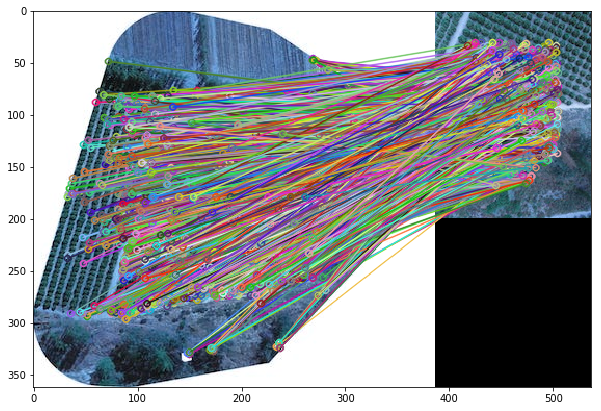

14


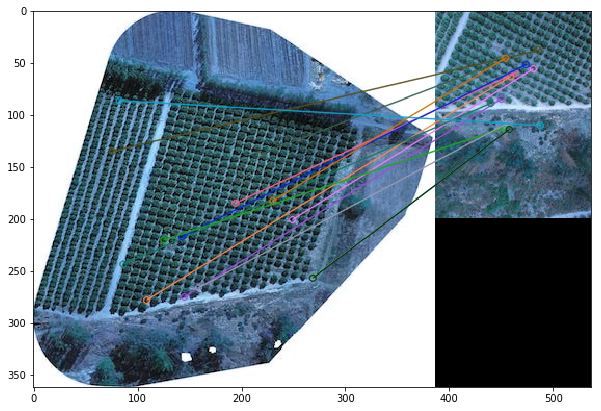

MAP: Calculated scale difference: 0.93, Calculated rotation difference: 179.03
Saving aligned image :  Outputs/aligned.jpg
Estimated homography : 
 [[-9.30640767e-01  1.57038106e-02  6.60352447e+01]
 [-1.49131094e+00 -1.21544280e-02  1.13992900e+02]
 [-1.28443834e-02 -3.69089219e-04  1.00000000e+00]]


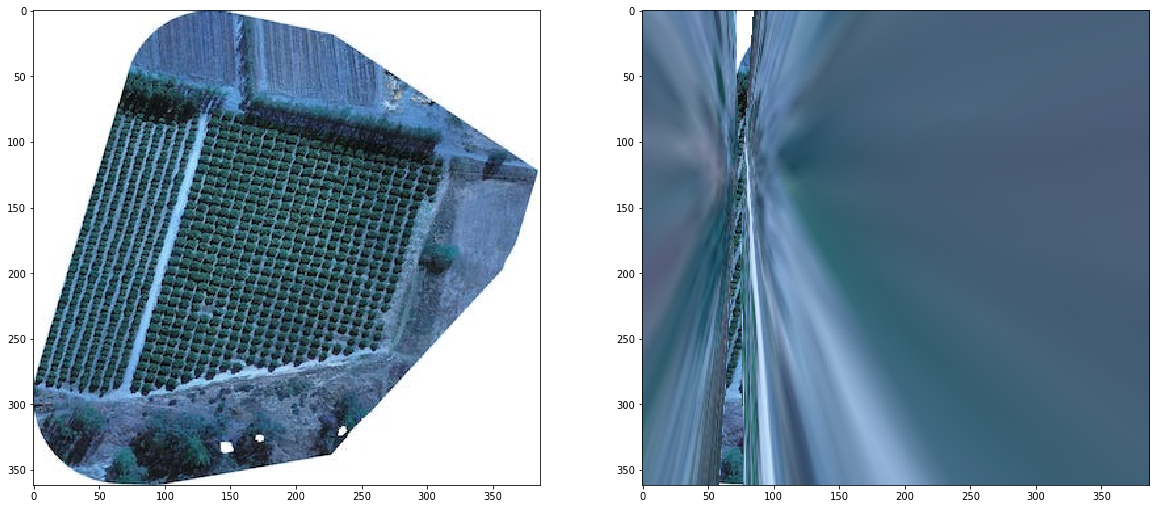

In [51]:
gooddist = 0.75
numpoints = 2000

def match_outlines(orig_image, skewed_image):
#         orig_image = cv2.resize(orig_image, (0,0), fx=0.5, fy=0.5) 
#         skewed_image = cv2.resize(skewed_image, (0,0), fx=0.5, fy=0.5) 
        
        orig_image = np.array(orig_image)
        skewed_image = np.array(skewed_image)
        
        surf = cv2.ORB_create(numpoints) 
        
        kp1, des1 = surf.detectAndCompute(orig_image, None)
        kp2, des2 = surf.detectAndCompute(skewed_image, None)
        
        des1 = np.float32(des1)
        des2 = np.float32(des2)
        
        FLANN_INDEX_KDTREE = 0
        index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
        search_params = dict(checks=50)
        flann = cv2.FlannBasedMatcher(index_params, search_params)
        matches = flann.knnMatch(des1, des2, k=2)
        
        # Draw matches
        imMatches = cv2.drawMatchesKnn(orig_image, kp1, skewed_image, kp2, matches, None, flags=2)

        fig = plt.figure(figsize=(10,10))
        plt.imshow(imMatches)
        plt.show()

        # store all the good matches as per Lowe's ratio test.
        good = []
        for m, n in matches:
            if m.distance < gooddist * n.distance:
                good.append(m)
                
        print(len(good))
        
        # Draw top matches
        imMatches = cv2.drawMatches(orig_image, kp1, skewed_image, kp2, good, None, flags=2)
        cv2.imwrite("Outputs/matches.jpg", imMatches)

        fig = plt.figure(figsize=(10,10))
        plt.imshow(imMatches)
        plt.show()

        MIN_MATCH_COUNT = 10
        if len(good) > MIN_MATCH_COUNT:
            src_pts = np.float32([kp1[m.queryIdx].pt for m in good
                                  ]).reshape(-1, 1, 2)
            dst_pts = np.float32([kp2[m.trainIdx].pt for m in good
                                  ]).reshape(-1, 1, 2)

            M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)

            # see https://ch.mathworks.com/help/images/examples/find-image-rotation-and-scale-using-automated-feature-matching.html for details
            ss = M[0, 1]
            sc = M[0, 0]
            scaleRecovered = np.sqrt(ss * ss + sc * sc)
            thetaRecovered = np.arctan2(ss, sc) * 180 / np.pi
            print("MAP: Calculated scale difference: %.2f, "
                          "Calculated rotation difference: %.2f" %
                          (scaleRecovered, thetaRecovered))

            #deskew image
            im_out = cv2.warpPerspective(skewed_image, np.linalg.inv(M),
                (orig_image.shape[1], orig_image.shape[0]))
            
            #ref is im2
            height, width, channels = orig_image.shape
            imgMask = np.ones(skewed_image.shape, dtype=np.uint8)
            imgMaskWarped = cv2.warpPerspective(imgMask, np.linalg.inv(M),
                (orig_image.shape[1], orig_image.shape[0]))
            imgMaskWarped = np.floor(cv2.bitwise_not(imgMaskWarped) / 255)
            
            im_out = orig_image * (imgMaskWarped.astype(orig_image.dtype)) + im_out
            
            return im_out, M

        else:
            print("MAP: Not  enough  matches are found   -   %d/%d"
                          % (len(good), MIN_MATCH_COUNT))
            return skewed_image, 0 
        
if __name__ == '__main__':
   
    # Read reference image
    refFilename = "Images/stitched_sunny_small.jpg"
    print("Reading reference image : ", refFilename)
    imReference = cv2.imread(refFilename, cv2.IMREAD_COLOR)
 
    # Read image to be aligned
    imFilename = "Images/drone_1_small.jpg"
    print("Reading image to align : ", imFilename);  
    im = cv2.imread(imFilename, cv2.IMREAD_COLOR)
    
    print("Aligning images ...")
    # Registered image will be stored in imReg. 
    # The estimated homography will be stored in h. 
    imReg, h = match_outlines(imReference, im)
   
    # Write aligned image to disk. 
    outFilename = "Outputs/aligned.jpg"
    print("Saving aligned image : ", outFilename); 
    cv2.imwrite(outFilename, imReg)
     
    # Print estimated homography
    print("Estimated homography : \n",  h)
    
    fig = plt.figure(figsize=(20,20))
    fig.add_subplot(1,2,1)
    plt.imshow(imReference)
    fig.add_subplot(1,2,2)
    plt.imshow(imReg)
        
    plt.show()

Reading reference image :  Images/stitched_cloudy_small.jpg
Reading image to align :  Images/drone_1_small.jpg
Aligning images ...


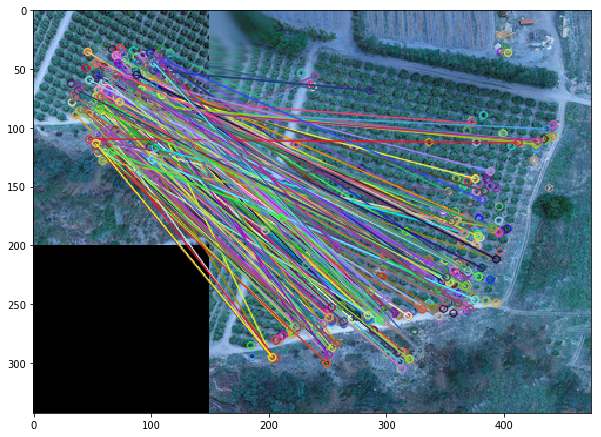

Saving aligned image :  Outputs/aligned.jpg
Estimated homography : 
 [[ 1.24117683e+00  1.81602366e-01  5.70719770e+00]
 [-2.03917411e-01  9.35374453e-01  1.86359648e+02]
 [-1.50764288e-05 -4.83405215e-04  1.00000000e+00]]


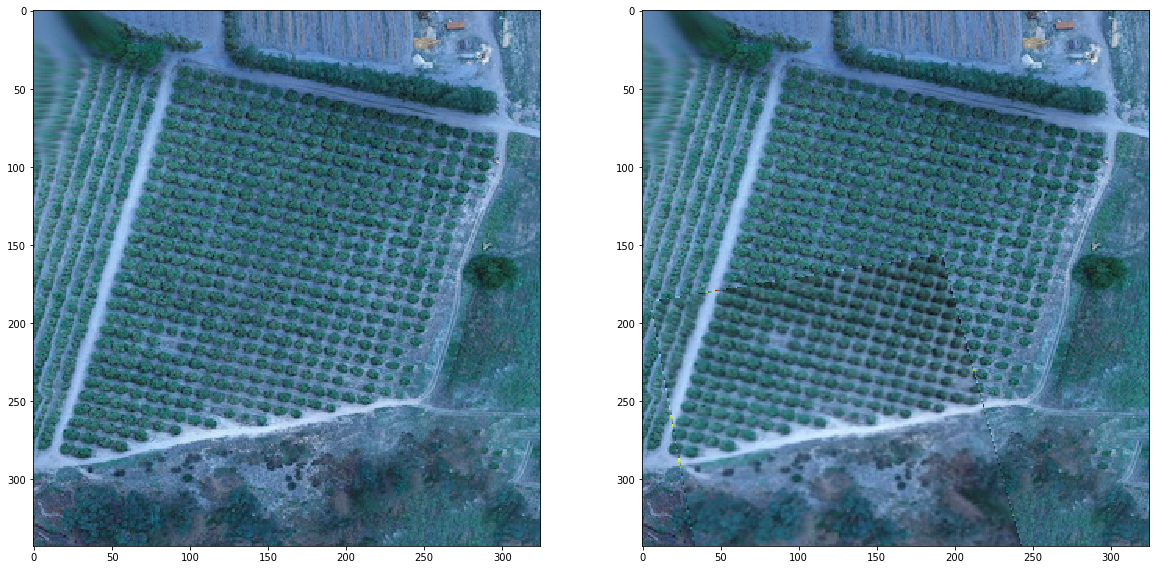

In [1]:
MAX_FEATURES = 500
GOOD_MATCH_PERCENT = 0.7
 
def alignImages(im1, im2):
 
    # Convert images to grayscale
    im1Gray = cv2.cvtColor(im1, cv2.COLOR_BGR2GRAY)
    im2Gray = cv2.cvtColor(im2, cv2.COLOR_BGR2GRAY)
        
#     thresh = 125
#     maxValue = 255
 
#     # Basic threshold to binary image
#     th, im1Bin = cv2.threshold(im1Gray, thresh, maxValue, cv2.THRESH_BINARY);
#     th, im2Bin = cv2.threshold(im2Gray, thresh, maxValue, cv2.THRESH_BINARY);
#     cv2.imwrite("bin.jpg", im1Bin)
    
#     # Initiate SIFT detector
#     #sift = cv2.SIFT()
#     sift = cv2.xfeatures2d.SIFT_create()

#     # find the keypoints and descriptors with SIFT
#     kp1, des1 = sift.detectAndCompute(img1,None)
#     kp2, des2 = sift.detectAndCompute(img2,None)

#     FLANN_INDEX_KDTREE = 0
#     index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
#     search_params = dict(checks = 50)

#     flann = cv2.FlannBasedMatcher(index_params, search_params)

#     allmatches = flann.knnMatch(des1,des2,k=2)

#     # store all the good matches as per Lowe's ratio test.
#     matches = []
#     for m,n in allmatches:
#         if m.distance < 0.7*n.distance:
#             matches.append(m)
   
      # Detect ORB features and compute descriptors.
    orb = cv2.ORB_create(MAX_FEATURES)
    keypoints1, descriptors1 = orb.detectAndCompute(im1Gray, None)
    keypoints2, descriptors2 = orb.detectAndCompute(im2Gray, None)
   
    # Match features.
#     matcher = cv2.DescriptorMatcher_create(cv2.DESCRIPTOR_MATCHER_BRUTEFORCE)
    matcher = cv2.DescriptorMatcher_create(cv2.DESCRIPTOR_MATCHER_BRUTEFORCE_HAMMING)
    matches = matcher.match(descriptors1, descriptors2, None)
   
    # Sort matches by score
    matches.sort(key=lambda x: x.distance, reverse=False)
 
    # Remove bad matches
    numGoodMatches = int(len(matches) * GOOD_MATCH_PERCENT)
    matches = matches[:numGoodMatches]
 
    # Draw top matches
    imMatches = cv2.drawMatches(im1, keypoints1, im2, keypoints2, matches, None)
    cv2.imwrite("Outputs/matches.jpg", imMatches)
        
    fig = plt.figure(figsize=(10,10))
    plt.imshow(imMatches)
    plt.show()
   
    # Extract location of good matches
    points1 = np.zeros((len(matches), 2), dtype=np.float32)
    points2 = np.zeros((len(matches), 2), dtype=np.float32)
 
    for i, match in enumerate(matches):
        points1[i, :] = keypoints1[match.queryIdx].pt
        points2[i, :] = keypoints2[match.trainIdx].pt
   
    # Find homography
    h, mask = cv2.findHomography(points1, points2, cv2.RANSAC)
 
    # Use homography
    height, width, channels = im2.shape
    im1Reg = cv2.warpPerspective(im1, h, (width, height))
    
    #ref is im2
    imgMask = np.ones(im1.shape, dtype=np.uint8)
    imgMaskWarped = cv2.warpPerspective(imgMask, h, (width, height));
    imgMaskWarped = np.floor(cv2.bitwise_not(imgMaskWarped) / 255)

    im1Reg = im2 * (imgMaskWarped.astype(im2.dtype)) + im1Reg
   
    return im1Reg, h
  
if __name__ == '__main__':
   
    # Read reference image
    refFilename = "Images/stitched_cloudy_small.jpg"
    print("Reading reference image : ", refFilename)
    imReference = cv2.imread(refFilename, cv2.IMREAD_COLOR)
 
    # Read image to be aligned
    imFilename = "Images/drone_1_small.jpg"
    print("Reading image to align : ", imFilename);  
    im = cv2.imread(imFilename, cv2.IMREAD_COLOR)
    
    print("Aligning images ...")
    # Registered image will be stored in imReg. 
    # The estimated homography will be stored in h. 
    imReg, h = alignImages(im, imReference)
   
    # Write aligned image to disk. 
    outFilename = "Outputs/aligned.jpg"
    print("Saving aligned image : ", outFilename); 
    cv2.imwrite(outFilename, imReg)
     
    # Print estimated homography
    print("Estimated homography : \n",  h)
    
    fig = plt.figure(figsize=(20,20))
    fig.add_subplot(1,2,1)
    plt.imshow(imReference)
    fig.add_subplot(1,2,2)
    plt.imshow(imReg)
        
    plt.show()

In [ ]:
from aeroimg.load import get_size_and_pixel_to_spatial_transform
size, pixel_to_spatial = get_size_and_pixel_to_spatial_transform("orthomosaic_visible.tif", dim_order='xy')
print(size)
spatial_to_pixel = ~pixel_to_spatial
lonlat_bottomleft = pixel_to_spatial((0,0))
# Similarly, can go from lonlat to pixel using "spatial_to_pixel" the same way 